In [1]:
%load_ext autoreload
%autoreload 2

# Heidelberg Workshop number ?

<a target="_blank" href="https://colab.research.google.com/github/etienneguevel/heidelberg/blob/main/notebooks/TD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

##  Setup
If running locally using jupyter, first intall the necessary libraries in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell.
In Colab, be sure to select 'GPU' under 'Resources'->'Modify the type of execution'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !git clone https://github.com/etienneguevel/heidelberg.git
    !{sys.executable} -m pip install heidelberg

![cell_proportion](./images/cell_proportion.png)

## Classification

Classification is a key task as the relative proportion of the different white blood cells
categories indicates the presence or not of a pathology.

This part's goal is to leverage an open-source dataset of white blood cells in order to
train a Deep Learning model to perform classification.

In [4]:
# Let's load the dataset
import medmnist
from medmnist import INFO, Evaluator, BloodMNIST

# We need to download the dataset it might take a while
train_dataset = BloodMNIST(split="train", size=64, download=True)
val_dataset = BloodMNIST(split="val", size=64, download=True)
test_dataset = BloodMNIST(split="test", size=64, download=True)

This dataset contains images of white blood cells that are divided between 8 categories:

- basophil
- eosinophil
- erythroblast
- immature granulocytes
- lymphocyte
- monocyte
- neutrophil
- platelet

### Understand an image

Image's class is: platelet



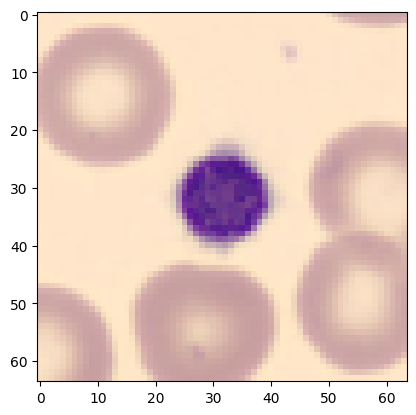

In [5]:
import random
import matplotlib.pyplot as plt

train_size = len(train_dataset)

label_dict = train_dataset.info["label"]
img, label = train_dataset[random.randint(0, train_size)]

print(f"Image's class is: {label_dict.get(str(label[0]))}\n")
plt.imshow(img)
plt.show()

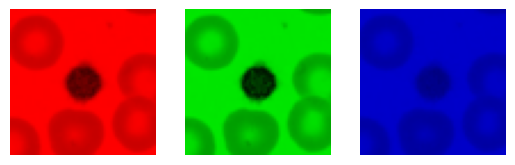

In [6]:
import numpy as np

image = np.array(img.convert("RGB"))
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:,:,i] = image[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

### Create the data objects

`torch` is a popular python framework to make Deep Learning models. Among its functionalities, it offers ways
to facilitate data usage through `Dataset` and `DataLoader` objects.  
The first step is to create a `Dataset` ([here](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)) object.  

You should implement three methods for that :
- `__init__` -> create attributes for our object
- `__len__` -> return the number of elements of our dataset (allows our object to get called with the `len` function)
- `__getitem__` -> return the element at an index (like for a `list`). In our case an item is made of an image transformed into a `tensor` + its label

In [7]:
# The first step is to make a dataset, for this we need to create our own custom object
# Below is the "backbone" of a Dataset object, with all the necessary methods that need to be implemented
# Uncomment and execute the cell below to see the answer
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, data, transform):
        # initialization method, you should store data and 
        pass

    def __len__(self):
        # should return the number of elements of the dataset
        pass

    def __getitem__(self, idx):
        # should return the element of the dataset at index idx
        # (Don't forget to transform the image)
        pass

In [ ]:
# %load ../src/custom_dataset.py

In [9]:
import torchvision.transforms as transforms

# Here we need a transform vision to convert the data which are PIL images into vectors
transform = transforms.ToTensor()

training_dataset = CustomDataset(train_dataset, transform)
validation_dataset = CustomDataset(val_dataset, transform)

Then we can make a dataloader in order to load the data by batches and accelerate
the training process

In [10]:
# Make your own dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(training_dataset, batch_size=64)
valid_loader = DataLoader(validation_dataset, batch_size=64)

# Let's check that the dataloader works
for images, labels in train_loader:
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape[1:]}")
    print(f"Labels shape: {labels.shape}")
    break

Batch size: 64
Image shape: torch.Size([3, 64, 64])
Labels shape: torch.Size([64, 1])


### Create the model

The model we are going to use for this task are Convolutional Neural Networks
([CNN](https://poloclub.github.io/cnn-explainer/)), and especially a family
of them called [ResNets](https://arxiv.org/abs/1512.03385).  


In [11]:
# We create a model from a pretrained point
from torchvision import models

model = models.resnet18(pretrained=True)

# We can see the blocks in our model like this
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/etienneguevel/Documents/cours/heidelberg/heidelberg/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etienneguevel/Documents/cours/heidelberg/heidelberg/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# We can see the number of parameters of our model like this
print(f"There are {sum([p.numel() for p in model.parameters()]):.2g} parameters in the model used.")

There are 1.2e+07 parameters in the model used.


In [13]:
# Bonus: You can also make your own model architecture!
# Uncomment and execute the cell below to see a simple CNN appear

import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        # create layers here
        # self.l1 = ...

    def forward(self, x):
        # here the output should be a vector of size num_classes
        pass

In [14]:
# %load ../src/net.py

### Training loop

In [15]:
# Now we need to make an optimizer + a loss
import torch.optim as optim

# cross-entropy loss is the one used for multi classification tasks
criterion = nn.CrossEntropyLoss()

# Adam is a popular optimizer, but other could be used (SGD, Adamw...)
optimizer = optim.Adam(model.parameters())

Now we have everything necessary in order to launch the training process.  
> ToDo : Find an image to illustrate training loop

In [16]:
# Implement the training loop here
# Uncomment and execute the cell below to see the answer

In [35]:
# %load ../src/training.py

### Visualize the results

Our dataset was split into three parts: train ,val and test. While we have used
the train for the backpropagation, and the val for monitoring, test is still
unseen to this point.

It's purpose is to the metrics at the endpoint of the training pipeline.

In [18]:
# Execute this cell to see the results of your trained model on the test dataset
from tqdm import tqdm

def find_accuracy(model, dataloader_test, device):
    correct = 0
    total = 0
    label_test = []
    predicted_test = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader_test):
            # Move the data to the device 
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Predict the label with the trained model
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            # Calculate the performance
            labels = labels.squeeze(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Add the predictions & labels in the list
            label_test.extend(labels.to('cpu').tolist())
            predicted_test.extend(preds.to('cpu').tolist())

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return predicted_test, label_test, correct / total

# Make the test dataset
testing_dataset = CustomDataset(test_dataset, transform)
test_loader = DataLoader(testing_dataset, batch_size=64)

# Specify the device
device = torch.device("cuda")
model.to(device)

# Calculate the results
predictions, labels, acc = find_accuracy(model, test_loader, device)

100%|██████████| 54/54 [00:00<00:00, 109.93it/s]

Accuracy of the network on the test images: 96 %


In classification problems, it is also important to check that the algorithm
has good performances on every classes, and not only on the most dominants.  

Indeed, in case of imbalanced dataset, training can be biased and less populated
classes have deteriorated performances.

/tmp/ipykernel_8473/2787801067.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                      precision    recall  f1-score   support

            basophil       0.96      0.98      0.97       244
          eosinophil       1.00      1.00      1.00       624
        erythroblast       1.00      0.93      0.97       311
immature granulocyte       0.92      0.91      0.92       579
          lymphocyte       0.93      0.98      0.95       243
            monocyte       0.90      0.96      0.93       284
          neutrophil       0.97      0.95      0.96       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.96      3421
           macro avg       0.96      0.96      0.96      3421
        weighted avg       0.96      0.96      0.96      3421



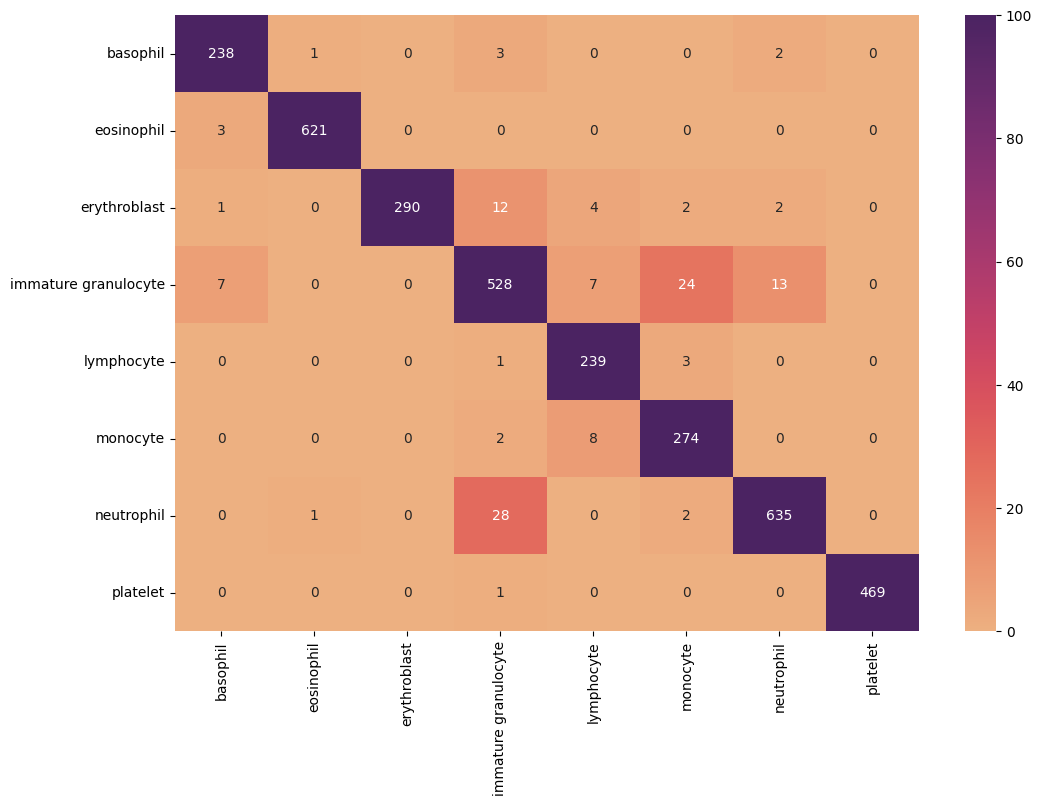

In [19]:
# Execute this cell to visualize the results of your model on the test set
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

names = [n[:20] for n in train_dataset.info.get("label").values()]

C_matrix = pd.DataFrame(confusion_matrix(labels, predictions))
C_matrix.index = names
C_matrix.columns = names

fig = plt.figure(figsize=(12, 8))
sns.heatmap(C_matrix, annot=True, cmap="flare", vmax=100, fmt='.3g')
fig.show()

print(classification_report(labels, predictions, target_names=names))

## Foundation models

*"Foundation models"* are called like this because their outputs, called **embeddings**
are not predictions but vectors of a shape $\mathbb{R}^n$.  
The embeddings are the angular stone used for other usages, which can be classification,
segmentation, multimodal models...

In theory every architecture can be used to make a fondation model, but in practice
[Transformers](https://poloclub.github.io/transformer-explainer/) are THE type of
model commonly used,  
and have been the workhorse of the AI ecosystem for the last 8 years.

### Vision Transformers (ViT)

[ViTs](https://arxiv.org/abs/2010.11929) are the adaptation of transformers to the use case of images; they take the image,
split them in squares that are embedded and then pass them through a Transformer Neural Network.  

![ViT_tokens](./images/ViT_token.png)

A **[CLS]** token is also added to the sequence of tokens, whose state at the output of the model serves as an **image representation**.
It is then used for the downstream tasks, like classification.  
> The [CLS] token is an artificial construction; it doesn't represent anything at the beginning, but his job is to concatenate the
information of the image patches in one embedding.

The [model](https://arxiv.org/abs/2404.05022) we are going to used in this part has been
trained on White Blood Cells images. It:
- Uses the Vision Transformer ([ViT](https://arxiv.org/abs/2010.11929)) architecture
- Uses [DINOv2](https://github.com/facebookresearch/dinov2) as training framework
- Was trained on ~300k images from open-sourced datasets
- Contains 4 models of different sizes, ranging from 22M to 1.1B of parameters

In [20]:
import timm

# Load model from the hub
model = timm.create_model(
  model_name="hf-hub:1aurent/vit_small_patch14_224.dinobloom", # you can change the size of the loaded model here
  pretrained=True,
).eval()

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

print("Below is the list of the layers contained within our model:\n")
model

Below is the list of the layers contained within our model:



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

Here we can see the architecture of the model that we use, which is very long.

Indeed it is made of 12 blocks, each having:
- An Attention layer
- A Mlp layer with one hidden layer
- Normalizing and Scaling layers in between

> Can you find the dimension of the embeddings of the model that you use ? What about its number of elements ?

In [21]:
# Try here, or uncomment and execute the cell below to see the answer

In [ ]:
# %load ../src/model_information.py

The dimension of the embeddings of the model is: 384

There are 2.21e+07 parameters in our model.


Image's class is: erythroblast



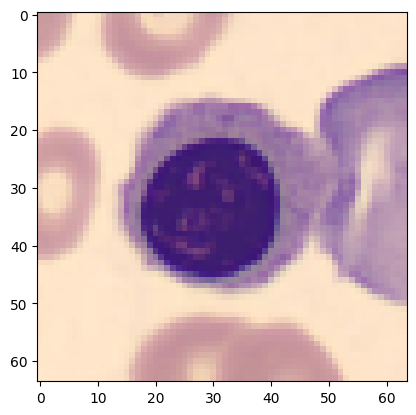

torch.Size([1, 384])

In [23]:
# Let's visualize a random image from the training set and use the model on it
img, label = train_dataset[random.randint(0, train_size)]

print(f"Image's class is: {label_dict.get(str(label[0]))}\n")
plt.imshow(img)
plt.show()
# Below is the code to use the model on a single image

data = transform(img).unsqueeze(0) # input is a (batch_size, num_channels, img_size, img_size) shaped tensor
output = model(data)
output.shape

### Probe the embeddings quality

Now that we have an easy access to the model embeddings, we can test their quality on the dataset
that we have used before.

Popular technics are:
- k-[Nearest-Neighbour](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) (k-NN), with k being usually 1 & 20
- [Linear Probing](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (ie fitting a linear classifier on the embeddings)

#### Make the dataset

Calculating the embeddings can be compute intensive, as we use transformer models
having huge amounts of parameters.  
However we only need to do that once, as we use them as mathematical objects, and
**we do not modify** the foumdation model afterwards.  

To do that we will create a Dataset object that will contain the embeddings calculated
for a model on a Dataset (the same as the one we used before).

In [25]:
# We are going to make a new dataset object in order to calculate the embeddings of the images.
# This allow to calculate once the embeddings and then reuse them for later applications
from heidelberg.embedding_dataset import EmbeddingDataset

# Make the embedding dataset and test shapes
emb_train = EmbeddingDataset(training_dataset, model, transform)
emb_test = EmbeddingDataset(testing_dataset, model, transform)

Calculating embeddings: 100%|██████████| 107/107 [02:34<00:00,  1.45s/batch]


Implement here the evaluation of the above mentionned techniques!  

> Tip: You can use the sklearn library for k-NN and Linear probing

In [ ]:
# Try to make function implementing the k-NN and linear probing of the embedding
# Uncomment and execute the cell below to get the answer

In [36]:
# %load ../src/embedding_evaluation.py

#### Visualize the embeddings

Visualisation of the embeddings in a 2D (x - y) plan is a good way to check the quality of our embeddings.  
Indeed, if the embeddings we produced are of a good quality, there should be clusters corresponding to each one
of our classes.  

Among popular dimensionality reduction techniques there are :
- [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html), a popular method for high dimensional biological datasets that captures well the clusters within a dataset
- [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)


In [302]:
# Try implementing one of the two techniques, and use the plot function below to get the 2D representation
# Uncomment the cell below for the answer

In [37]:
# %load ../src/umap_tsne.py

In [31]:
import pandas as pd
import seaborn as sns

def plot_embeddings(embs, labels):
    
    # Make a dataframe with the embeddings
    data = pd.DataFrame(
        [
            [e[0], e[1], translate_dict.get(str(lab[0]))[:20]]
            for e, lab in zip(embs, labels)
        ],
        columns=["x", "y", "class"]
    )

    sns.relplot(
        data=data,
        x="x", y="y", hue="class", style="class", height=8, aspect=1.5
    )
    plt.show()

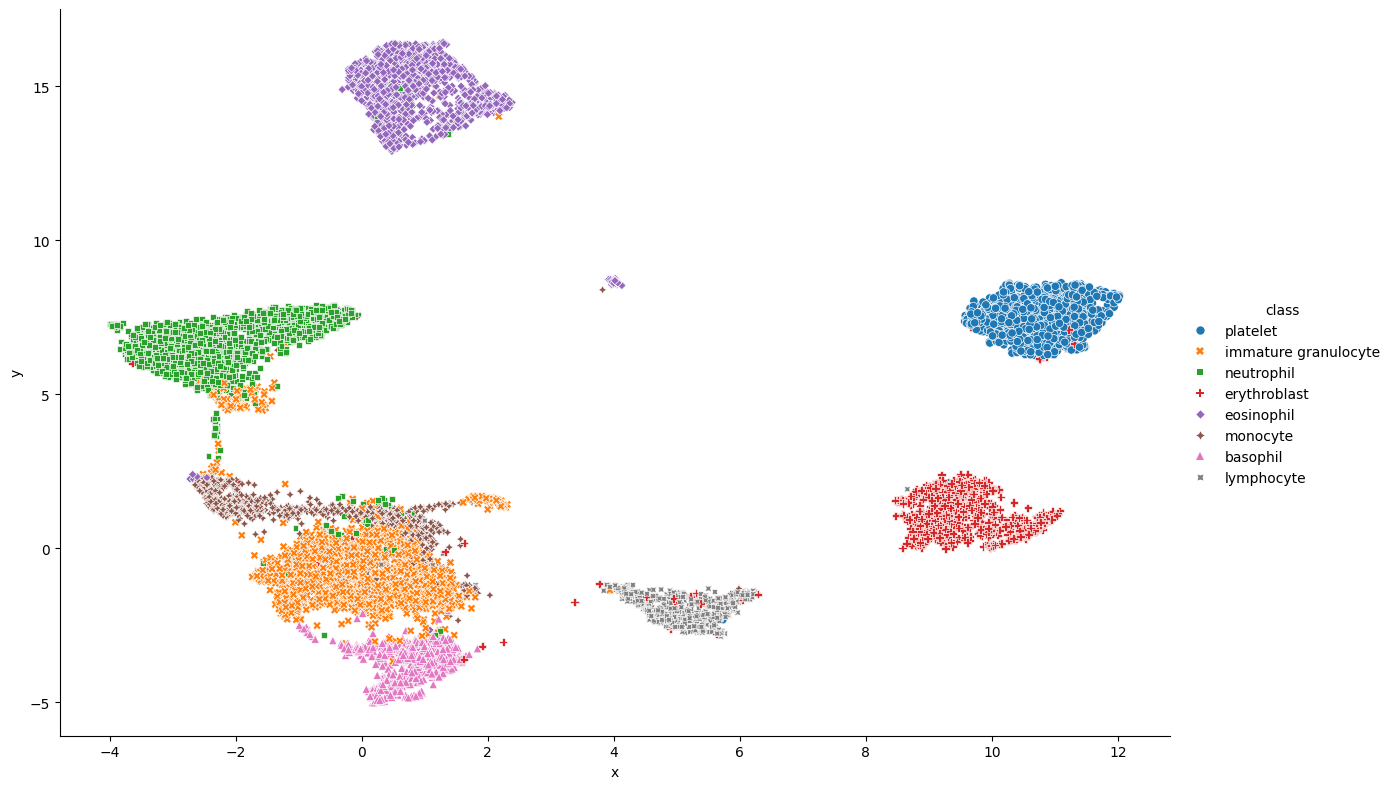

In [32]:
uemb, labels = get_umap(emb_train)
plot_embeddings(uemb, labels)

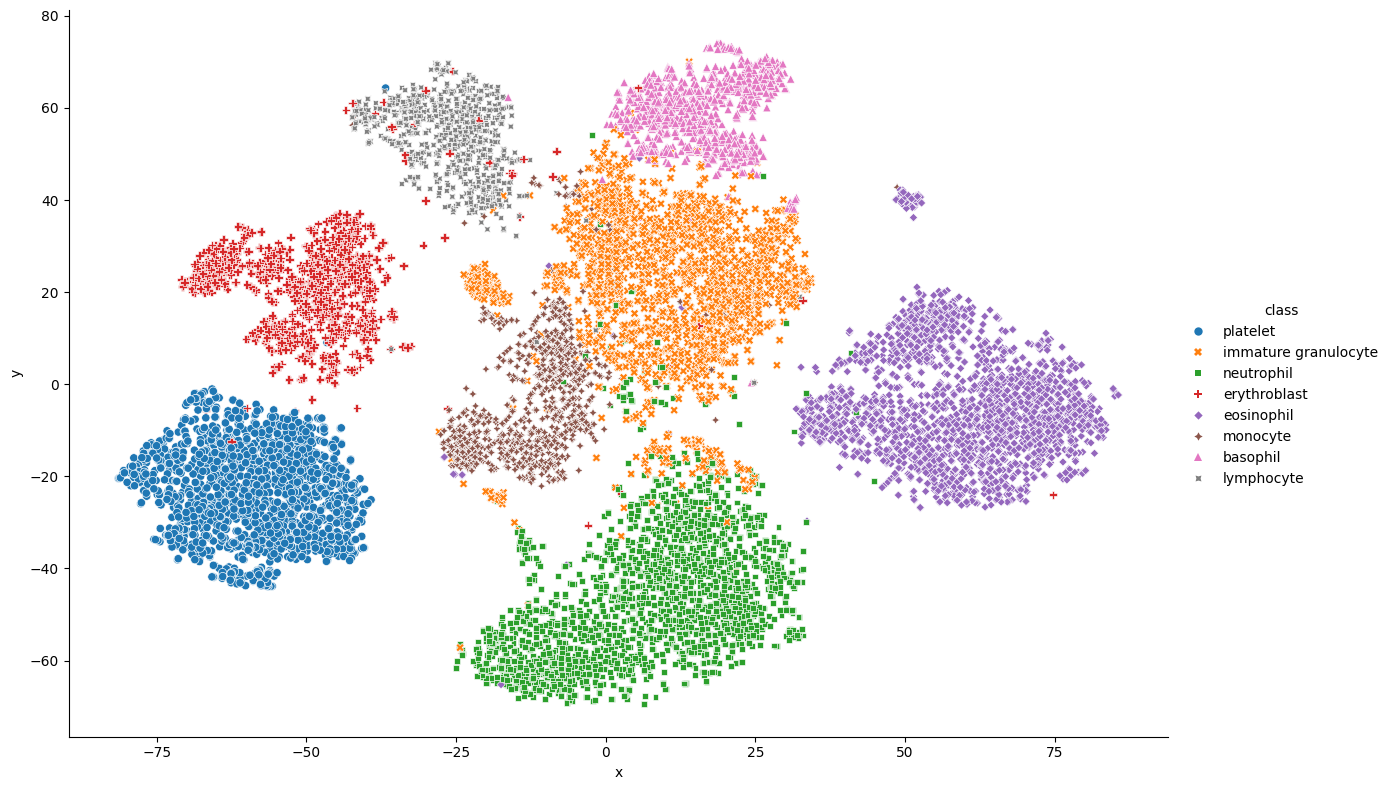

In [33]:
temb, labels = get_tsne(emb_train)
plot_embeddings(temb, labels)

### Bonus : Attention map

As of now we almost only used the [CLS] token, and left alone the tokens of the image patches.  

Embeddings of an image evolve from one layer to another, and are calculated through the attention mechanism.  
In the attention mechanism new tokens are updated according to their similarity with other tokens (the more similar,
the more their update will be consequent).


As such, one interesting thing to look at is the **attention map of the [CLS] token in the last layer**,
as it kind of indicate which parts of the images are most used for the creation the image's embedding.

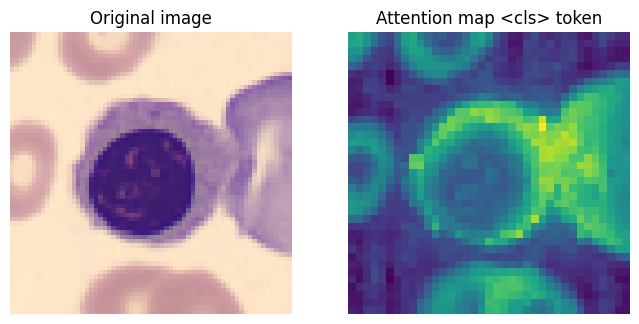

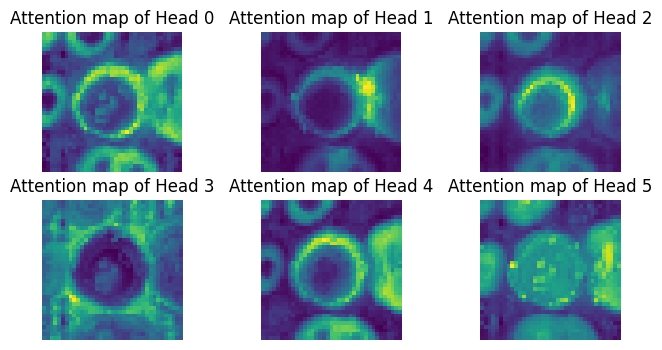

In [34]:
from heidelberg.attn import get_attn

patch_h, patch_w = 37, 37
model.cpu()

def plot_attention_map(img, layer, model, save=False):
    img_tensor = transform(img)
    cls_attn = get_attn(img_tensor, model, layer)
    num_heads, _ = cls_attn.shape
    
    cls_tot = torch.sum(cls_attn, dim=0).reshape((patch_h, patch_w))
    
    img_or = np.array(img) 
    # Plot the total attention (summed over the heads)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(img_or)
    ax[0].axis("off")
    ax[0].set_title("Original image")
    ax[1].imshow(cls_tot)
    ax[1].axis("off")
    ax[1].set_title("Attention map <cls> token")
    
    if save:
        plt.savefig("attention_map_cls.png")
    plt.show()

    # Plot the attention of the heads
    k, l = 3, num_heads // 3 + (num_heads % 3 != 0)
    fig, ax = plt.subplots(l, k, figsize=(8, 4))

    for i in range(l):
        for j in range(k):
            attn_map = cls_attn[3 * i + j, :].reshape((patch_h, patch_w))
            ax[i][j].imshow(attn_map)
            ax[i][j].axis("off")
            ax[i][j].set_title(f"Attention map of Head {3 * i + j}")
    plt.show()

last_layer = [blk for blk in model.blocks][-1]
plot_attention_map(img, last_layer, model)